***Ex. 1.*** Un site web doreşte să prezică rata zilnică p a utilizatorilor care finalizează o achiziţie. Se observă date zilnice privind
numărul k de utilizatori care finalizează achiziţia şi numărul total n de vizitatori zilnici (astfel, p = k/n), timp de o
săptămână. Observaţiile sunt:

● Ziua 1: k = 10, n = 100;

● Ziua 2: k = 15, n = 120;

● Ziua 3: k = 20, n = 150;

● Ziua 4: k = 5, n = 90;

● Ziua 5: k = 25, n = 200;

● Ziua 6: k = 12, n = 110;

● Ziua 7: k = 18, n = 130.

Dorim să estimăm rata pentru fiecare zi a săptămânii, dar şi rata medie. Presupunem că:

● rata zilnică p urmează o distribuţie Beta(α = 2, β = 2), care reflectă o preferinţă uşoară pentru valori apropiate
de 0.5, iar

● pentru fiecare zi, numărul de utilizatori care finalizează achiziţia ki este modelat ca o variabilă binomială:

ki ∼ Binomial(ni, pi),

unde ni este numărul total de utilizatori în ziua i.

a) Definiţi un model în PyMC care sa descrie contextul de mai sus.
b) Estimaţi distribuţia a posteriori pentru fiecare pi, dar şi pentru rata medie globală pmean = 1/7 * (p1 + . . . + p7).

In [1]:
import pymc as pm
import numpy as np

# Datele observate
k = np.array([10, 15, 20, 5, 25, 12, 18])  # utilizatori care au finalizat achiziția
n = np.array([100, 120, 150, 90, 200, 110, 130])  # utilizatori total

with pm.Model() as model:
    # Prior pentru ratele zilnice: Beta(2, 2)
    p = pm.Beta("p", alpha=2, beta=2, shape=len(k))
    
    # Observații: k_i ∼ Binomial(n_i, p_i)
    k_obs = pm.Binomial("k_obs", n=n, p=p, observed=k)
    
    # Calculul ratei medii globale
    p_mean = pm.Deterministic("p_mean", pm.math.mean(p))


WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
with model:
    # Eșantionare
    trace = pm.sample(2000, tune=1000, return_inferencedata=True, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 67 seconds.


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
p[0]    0.115  0.031   0.060    0.175        0.0      0.0    9101.0    6544.0   
p[1]    0.137  0.031   0.081    0.194        0.0      0.0   11507.0    6687.0   
p[2]    0.143  0.028   0.092    0.198        0.0      0.0   10886.0    6760.0   
p[3]    0.075  0.027   0.028    0.125        0.0      0.0   10877.0    6100.0   
p[4]    0.132  0.023   0.088    0.174        0.0      0.0    9954.0    6685.0   
p[5]    0.122  0.030   0.068    0.181        0.0      0.0   10573.0    5992.0   
p[6]    0.149  0.031   0.096    0.209        0.0      0.0   10574.0    6862.0   
p_mean  0.125  0.011   0.104    0.144        0.0      0.0   10326.0    6969.0   

        r_hat  
p[0]      1.0  
p[1]      1.0  
p[2]      1.0  
p[3]      1.0  
p[4]      1.0  
p[5]      1.0  
p[6]      1.0  
p_mean    1.0  


array([[<Axes: title={'center': 'p\n0'}>,
        <Axes: title={'center': 'p\n1'}>,
        <Axes: title={'center': 'p\n2'}>,
        <Axes: title={'center': 'p\n3'}>],
       [<Axes: title={'center': 'p\n4'}>,
        <Axes: title={'center': 'p\n5'}>,
        <Axes: title={'center': 'p\n6'}>,
        <Axes: title={'center': 'p_mean'}>]], dtype=object)

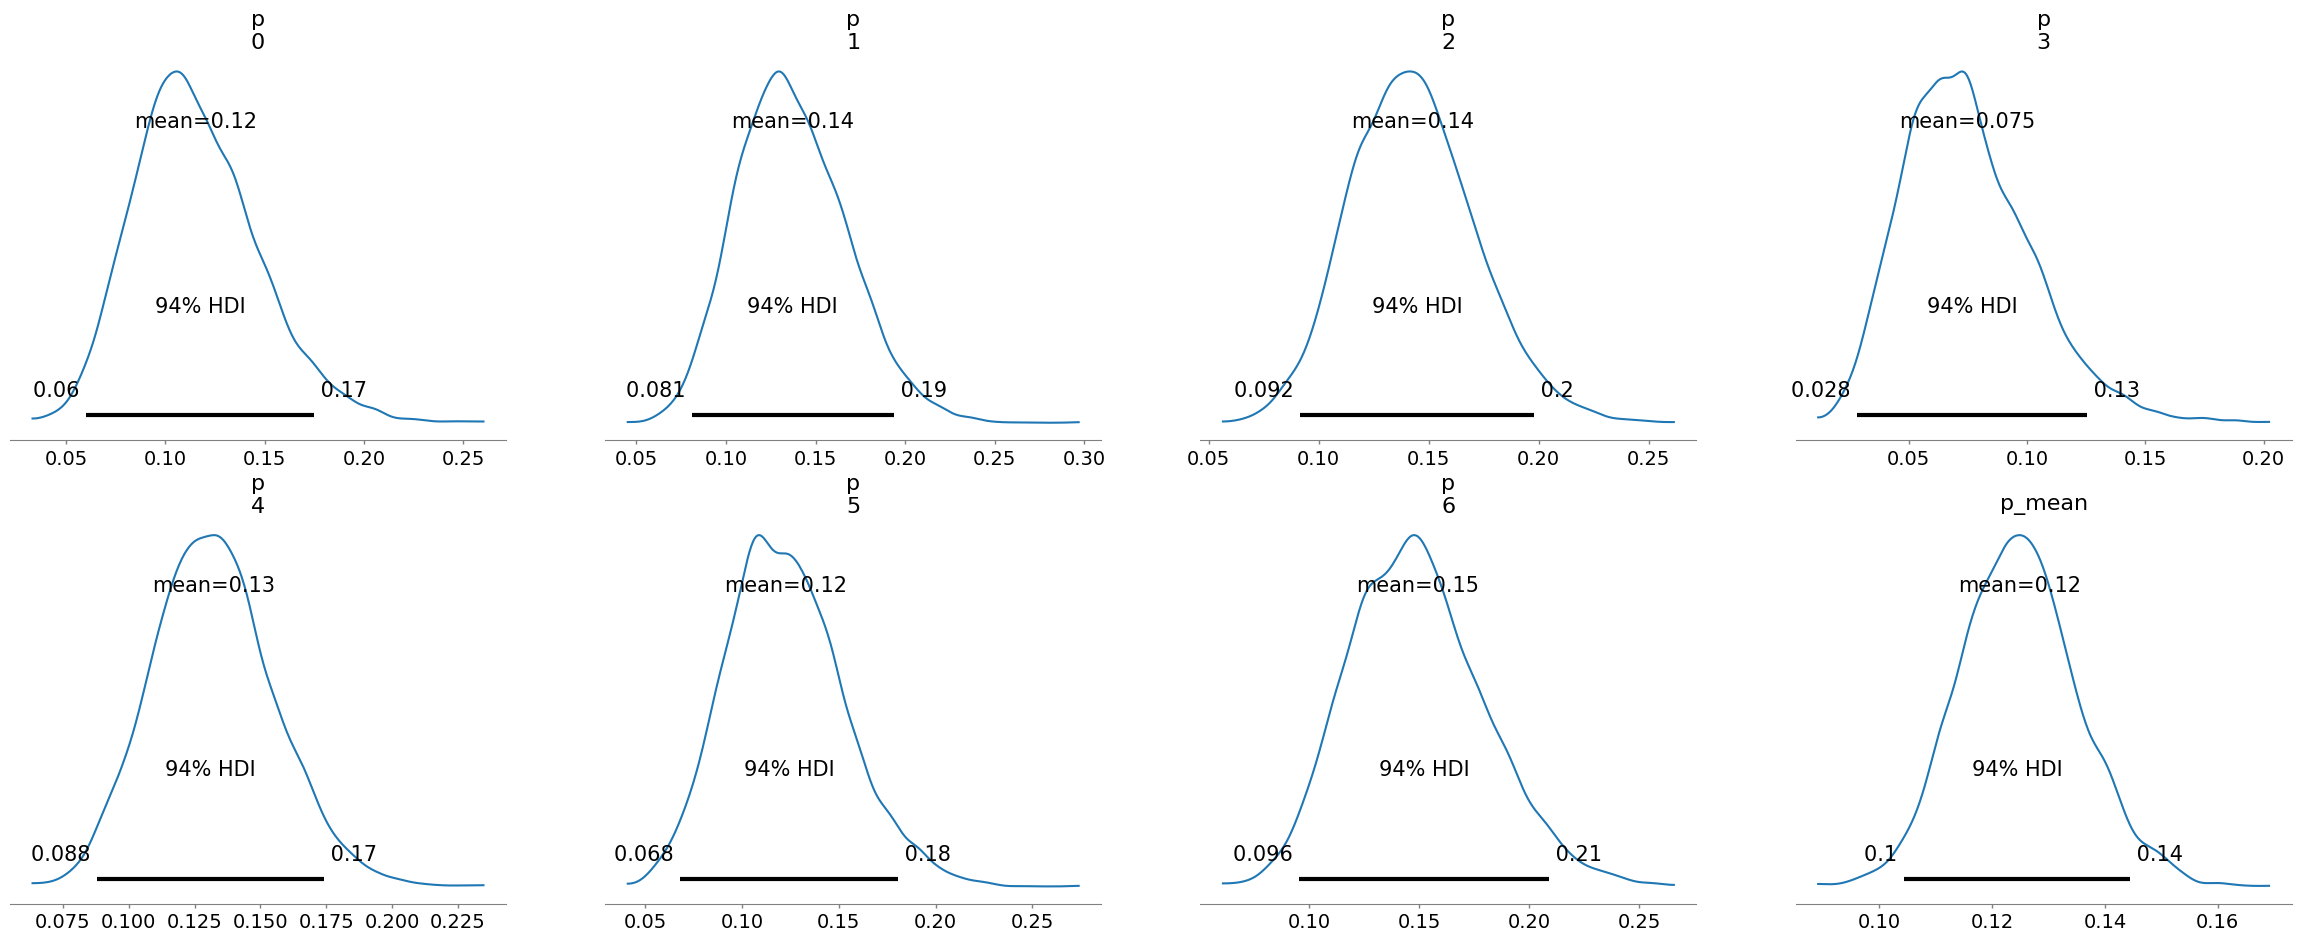

In [3]:
import arviz as az

# Rezumat numeric al distribuțiilor a posteriori
print(az.summary(trace, var_names=["p", "p_mean"]))

# Vizualizare grafică a distribuțiilor
az.plot_posterior(trace, var_names=["p", "p_mean"])

***Ex. 2.*** Valorile de trafic (masini/min.) înregistrate de o camera in jurul unei anumite intersectii din oraş, într-o zi normală,
sunt redate în fişierul trafic.scv (în fiecare minut, de la ora 4:00 până la 24:00). Presupunem că valorile respective sunt
determinate de o distribuţie Poisson de parametru necunoscut λ > 0. Se ştie că modificări ale mediei traficului au loc în
jurul orelor 7, 16 (creştere) şi 8, 19 (descreştere).

a) Definiţi un model probabilist care sa descrie contextul de mai sus, folosind PyMC.

b) Determinaţi capetele cele mai probabile ale celor 5 intervale de timp, cât şi cele mai probabile valori ale parametru-
lui λ în acele intervale.

In [ ]:
import pymc as pm
import numpy as np
import pandas as pd

# we load the traffic data
data = pd.read_csv("trafic.csv")
minute = data["minut"].values
observed_traffic = data["nr. masini"].values

# aggregate data into 5-minute intervals for efficiency
data["interval"] = (data["minut"] // 5) * 5
aggregated = data.groupby("interval").mean().reset_index()
minute = aggregated["interval"].values
observed_traffic = aggregated["nr. masini"].values

with pm.Model() as model:
    # change points as continuous variables:
    cp_continuous = pm.Uniform("cp_continuous", lower=240, upper=1200, size=4)
    change_points = pm.Deterministic("change_points", pm.math.round(cp_continuous))

    # define rate parameters (λ) for the 5 intervals
    lambda_values = pm.Gamma("lambda_values", alpha=2, beta=1, size=5)

    # assign λ to minutes based on the change points
    lambda_minute = lambda_values[0]
    for i in range(4):
        lambda_minute = pm.math.switch(minute >= change_points[i], lambda_values[i + 1], lambda_minute)

    # observations
    observed = pm.Poisson("observed", mu=lambda_minute, observed=observed_traffic)

# perform inference
with model:
    step = pm.NUTS(target_accept=0.95)
    trace = pm.sample(2000, tune=1000, step=step, cores=4)

# extract results
change_points_samples = trace.posterior["change_points"].values
lambda_samples = trace.posterior["lambda_values"].values

# calculate the most probable values
most_probable_change_points = np.median(change_points_samples, axis=(0, 1))
most_probable_lambda_values = np.median(lambda_samples, axis=(0, 1))

print("Most probable change points (in minutes):")
print(most_probable_change_points)

print("Most probable values of λ:")
print(most_probable_lambda_values)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cp_continuous, lambda_values]


Output()

In [ ]:
# sampling
with model:
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)

# getting estimates
change_points_samples = trace.posterior["change_points"].values
lambda_samples = trace.posterior["lambda_values"].values

# most probable change points
most_probable_change_points = np.median(change_points_samples, axis=(0, 1))
most_probable_lambda_values = np.median(lambda_samples, axis=(0, 1))

print("Limits of the most probably intervals (minutes):")
print(most_probable_change_points)

print("Most probably value of λ:")
print(most_probable_lambda_values)
